In [3]:
# these imports are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("..")
from typing import Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from utils import physics
from utils import LaserModel as LM
from scipy.constants import c 

|   iter    |  target   |    d2     |    d3     |    d4     |
-------------------------------------------------------------
|  1        | -0.1429   | -16.95    |  11.2     | -2.464    |
|  2        | -0.1034   |  8.939    |  19.12    |  1.54     |
|  3        | -0.1304   |  0.04482  | -17.12    | -9.262    |
|  4        | -0.1005   | -0.0047   |  7.169    |  12.15    |
|  5        | -0.1004   | -4.762    | -17.36    | -8.474    |
|  6        | -0.1262   |  16.38    | -11.46    | -1.915    |
|  7        | -0.1379   |  17.25    | -19.0     |  4.022    |
|  8        | -0.1075   |  18.01    | -10.79    |  1.94     |
|  9        | -0.1368   |  16.37    | -14.67    |  0.9365   |
|  10       | -0.08057  |  10.02    |  6.761    | -1.29     |
|  11       | -0.2221   | -11.81    | -0.3694   | -5.105    |
|  12       | -0.1502   | -0.904    | -5.364    |  13.52    |
|  13       | -0.08788  |  10.75    | -7.44     |  2.905    |
|  14       | -0.2384   | -8.958    | -1.886    | -5.881    |
|  15   

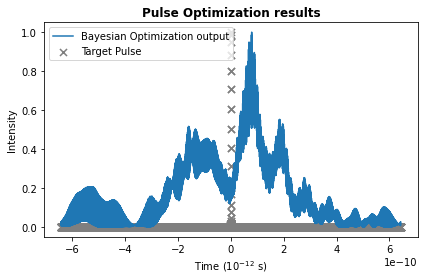

Final MSE between Control and Target: 5.9605e-02


In [26]:
def convert_control(control:np.array) -> np.array: 
    """This function converts the control from SI units to ps/nm, ps/nm^2 and ps/nm^3. 

    Args:
        control (np.array): The control applied in SI units. 

    Returns:
        np.array: The control applied in ps/nm, ps/nm^2 and ps/nm^3.
    """
    d2, d3, d4 = control
    d2_new = d2 * 1e-3 # from ps/nm to s/m 
    d3_new = d3 * 1e+6 # from ps/(nm^2) to s/(m^2)
    d4_new = d4 * 1e+15 # from ps/(nm^3) to s/(m^3)

    return np.array((d2_new, d3_new, d4_new))

def extract_data()->Tuple[np.array, np.array]: 
    """This function extracts the desired information from the data file given.
    
    Returns: 
        Tuple[np.array, np.array]: Frequency (in THz) and Intensity arrays.

    """
    data_path = "../data/L1_pump_spectrum.csv"
    # read the data
    df = pd.read_csv(data_path, header = None)
    df.columns = ["Wavelength (nm)", "Intensity"]
    # converting Wavelength (nm) to Frequency (Hz)
    df["Frequency (THz)"] = df["Wavelength (nm)"].apply(lambda wavelenght: 1e-12 * (c/(wavelenght * 1e-9)))
    # clipping everything that is negative - measurement error
    df["Intensity"] = df["Intensity"].apply(lambda intensity: np.clip(intensity, a_min = 0, a_max = None))
    # the observations must be returned for increasing values of frequency
    df = df.sort_values(by = "Frequency (THz)")

    frequency, intensity = df.loc[:, "Frequency (THz)"].values, df.loc[:, "Intensity"].values
    # mapping intensity in the 0-1 range
    intensity = (intensity - intensity.min()) / (intensity.max() - intensity.min())
    
    return frequency, intensity

def model(frequency, intensity, compressor, b_int, cutoff)->object: 
    """
    Returns the model instantiated with respect to arguments. 
    Consistency of arguments type is assumed in this function.
    """
    l1_pump = LM.LaserModel(
        frequency = frequency, 
        intensity = intensity,
        compressor_params = compressor, 
        B = b_int, 
        cutoff = cutoff)
    
    return l1_pump


frequency, intensity = extract_data() # extracting the desired information

COMPRESSOR = np.array((1.97107 * 1e-22, -3.36446 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
B = 2
CUTOFF = (289.95, 291.91) # cutoff frequencies, in THz

l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF)
# pre-processed version of frequency and intensity
frequency_clean, intensity_clean = l1_pump.spit_center()

time, profile_TL = physics.temporal_profile(
    frequency_clean,
    np.sqrt(intensity_clean),
    phase = np.zeros_like(frequency_clean),
    npoints_pad = l1_pump.pad_points
)

objective_function = lambda d2, d3, d4: -1 * physics.mse(
                                                        l1_pump.forward_pass(
                                                            convert_control((d2, d3, d4))
                                                                            )[1],
                                                        profile_TL)

# these are the bounds for the parameter currently optimized. 
# These are specific for the actual laser rather than being specific for the signal.
d2_low, d2_high = -20, +20
d3_low, d3_high = -20, +20
d4_low, d4_high = -20, +20

pbounds = {
    "d2": (d2_low, d2_high), 
    "d3": (d3_low, d3_high), 
    "d4": (d4_low, d4_high)
}

optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=7,
)

# these are hyperparameters of the optimization process
n_init, n_iter = 50, 10
optimizer.maximize(
    init_points=n_init,
    n_iter=n_iter,
)

# plotting the result obtained with Bayesian Optimization
optimald2, optimald3, optimald4 = optimizer.max["params"]["d2"], optimizer.max["params"]["d3"], optimizer.max["params"]["d4"]

optimal_control = convert_control(np.array([optimald2, optimald3, optimald4]))
# applying optimal control found
time_BO, profile_BO = l1_pump.forward_pass(optimal_control)

fig, ax = plt.subplots()
ax.set_title("Pulse Optimization results", fontsize = 12, fontweight = "bold")
ax.plot(time_BO, profile_BO, label = "Bayesian Optimization output")
ax.scatter(time, profile_TL, label = "Target Pulse", c = "tab:grey", marker = "x", s = 50)
ax.set_xlabel(r"Time ($10^{-12}$ s)"); ax.set_ylabel("Intensity")

ax.legend()
#ax.set_xlim(left = -0.05e-11, right = +0.05e-11)
fig.tight_layout()
plt.show()

print("Final MSE between Control and Target: {:.4e}".format(-1*objective_function(optimald2, optimald3, optimald4)))

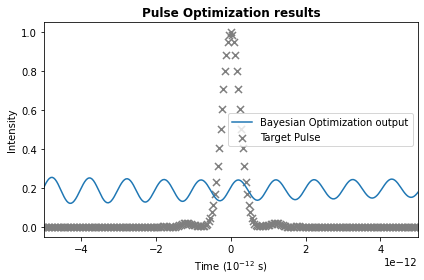

Final MSE between Control and Target: 5.9605e-02


In [27]:
# plotting the result obtained with Bayesian Optimization
optimald2, optimald3, optimald4 = optimizer.max["params"]["d2"], optimizer.max["params"]["d3"], optimizer.max["params"]["d4"]

optimal_control = convert_control(np.array([optimald2, optimald3, optimald4]))
# applying optimal control found
time_BO, profile_BO = l1_pump.forward_pass(optimal_control)

fig, ax = plt.subplots()
ax.set_title("Pulse Optimization results", fontsize = 12, fontweight = "bold")
ax.plot(time_BO, profile_BO, label = "Bayesian Optimization output")
ax.scatter(time, profile_TL, label = "Target Pulse", c = "tab:grey", marker = "x", s = 50)
ax.set_xlabel(r"Time ($10^{-12}$ s)"); ax.set_ylabel("Intensity")

ax.legend()
ax.set_xlim(left = -0.05e-10, right = +0.05e-10)
fig.tight_layout()
plt.show()

print("Final MSE between Control and Target: {:.4e}".format(-1*objective_function(optimald2, optimald3, optimald4)))

In [23]:
optimizer.max["params"]

{'d2': 215.5095925174861, 'd3': -318.6636174084027, 'd4': -344.2484464724816}